# Improvements vs v1

Functions:
- Documentation of classes and functions.

Data cleaning:
- Outliers inspection, using the Interquartile Range (IQR) method.

EDA:
- Complements in univariate analysis, such as target, numerical and categorical analysis.
- Complements in bivariate analysis, with improvements in data interpretation, creation and validation of hypotheses, and new ideas for feature engineering.
- Implementation of multivariate analysis, evaluating Pearson's correlation and Cramér's V.

# Planning

Business problem:
- The financial institution has an estimated churn retention rate of 28%/year.
- A new retention goal was announced for next year, which is 40%. To achieve this, the customer retention team needs a churn prediction model.
- The model must be at least 55% effective in identifying true churners, while avoiding false positives.
- This way, the retention team will act using the model to reverse at least 80% of churns, which results in 44% retention, reaching the goal.

Problem type: Binary Classification
- The 'abandono_clientes.csv' dataset contains 10k rows and 13 features, which is enough to create a supervised machine learning model using a frequentist approach.
- To deal with this churn problem, some classification models with different approaches will be created, and the best one will be used.

Evaluation metric: F1 score 
- F1 score will be the metric used with cross-validation, considering:
    - The business team needs a good balance between finding actual churners (recall) and avoiding false alarms (precision). 
    - Focuses on minority class (churners) performance without being skewed by majority class dominance (imbalanced dataset: 20% churned).

Methodology: CRISP-DM
- Cross Industry Standard Process for Data Mining methodology will be used, being cyclical and flexible, in order to take advantage of best market practices.

Project deliverables:
- EDA Notebook with:
    - Statistical analysis of data.
    - Business Insights from variables.
- Modeling Notebook with: 
    - Churn prediction model with a baseline > 0.55 on test data: 55% effectiveness in identifying true churners.
    - Model Explainability.
    - Business and financial results.
- CSV file with:
    - 'abandono_result.csv' file, being the model predictions from 'abandono_teste.csv'.

# Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
from scipy.stats import shapiro, chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import sweetviz as sv  #requires numpy downgrade (numpy==1.26.0)

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

sns.set_palette("deep") #Set seaborn's built-in palettes

## Functions

In [2]:
def statistics(data):
    """Calculate comprehensive descriptive statistics for numerical data.
    
    Computes various statistical metrics including central tendency, dispersion, and distribution shape for all numeric columns in the input DataFrame.
    
    Parameters
    ----------
    data : pandas.DataFrame
        Input DataFrame containing numerical columns
        
    Returns
    -------
    pandas.DataFrame
        DataFrame with the following statistics for each numeric column:
        - non-null : int
            Count of non-null values
        - range : float
            Difference between maximum and minimum values
        - min : float
            Minimum value
        - quant25 : float
            First quartile (25th percentile)
        - median : float
            Median (50th percentile)
        - quant75 : float
            Third quartile (75th percentile)
        - max : float
            Maximum value
        - mean : float
            Arithmetic mean
        - std : float
            Standard deviation
        - skew : float
            Skewness (measure of distribution asymmetry)
        - kurtosis : float
            Kurtosis (measure of distribution tailedness)
            
    Notes
    -----
    - All metrics are rounded to 1 decimal place
    - Only columns with int or float datatypes are analyzed
    - NaN values are automatically excluded from calculations
    
    Examples
    --------
    >>> df = pd.DataFrame({
    ...     'A': [1, 2, 3, 4, 5],
    ...     'B': [2.5, 3.5, 4.5, 5.5, 6.5],
    ...     'C': ['a', 'b', 'c', 'd', 'e']
    ... })
    >>> stats = statistics(df)
    >>> print(stats.columns)
    Index(['non-null', 'range', 'min', 'quant25', 'median', 'quant75', 'max', 'mean', 'std', 'skew', 'kurtosis'], dtype='object')
    """
    # Select only numeric columns
    num_data = data.select_dtypes(include=['int', 'float'])

    # Central Tendency
    mean = num_data.apply(np.mean)
    q50 = num_data.quantile(0.5)

    # Quantiles
    q25 = num_data.quantile(0.25)
    q50 = num_data.quantile(0.5)
    q75 = num_data.quantile(0.75)
    range_ = num_data.apply(lambda x: x.max() - x.min())
    count = num_data.count()

    # Dispersion
    min_ = num_data.apply(min)
    max_ = num_data.apply(max)
    std = num_data.apply(np.std)

    # Distribution Shape
    skew = num_data.apply(lambda x: x.skew())
    kurtosis = num_data.apply(lambda x: x.kurtosis())

    metrics = pd.DataFrame({
        'non-null': count,
        'range': range_,
        'min': min_,
        'quant25': q25,
        'median': q50,
        'quant75': q75,
        'max': max_,
        'mean': mean,
        'std': std,
        'skew': skew,
        'kurtosis': kurtosis
    })
    
    return np.round(metrics, 1)


In [3]:
class RenameDfColumns(BaseEstimator, TransformerMixin):
    """Transform DataFrame column names to snake_case format.
    
    A scikit-learn transformer that converts all column names in a pandas DataFrame to snake_case naming convention using the inflection library.
        For example: 'FirstName' becomes 'first_name', 'DOB' becomes 'dob'.
    
    Attributes
    ----------
    None
    
    Methods
    -------
    fit(X, y=None)
        No-op method that returns self (required for scikit-learn API).
    transform(X, y=None)
        Converts DataFrame column names to snake_case.
    """
    def fit(self, X, y=None):
        """No-op method required for scikit-learn transformer API.
        
        Parameters
        ----------
        X : pandas.DataFrame
            Input DataFrame, not used
        y : None
            Ignored
            
        Returns
        -------
        self : object
            Returns self
        """
        return self
    
    def transform(self, X, y=None):
        """Transform DataFrame column names to snake_case.
        
        Parameters
        ----------
        X : pandas.DataFrame
            DataFrame whose columns need to be renamed
        y : None
            Ignored
            
        Returns
        -------
        pandas.DataFrame
            A copy of input DataFrame with renamed columns
        """
        return X.copy().rename(columns=lambda x: inflection.underscore(x))

In [4]:
class FilterFeatures(BaseEstimator, TransformerMixin):
    """Remove specified columns from a DataFrame.
    
    A scikit-learn transformer that removes specified columns from a pandas DataFrame.
    If no columns are specified during initialization, no columns will be removed.
    
    Parameters
    ----------
    columns : list or None, default=None
        List of column names to remove from the DataFrame.
        If None or empty list, no columns will be removed.
    
    Attributes
    ----------
    columns : list
        List of columns to be removed. Empty list if no columns specified.
    
    Examples
    --------
    >>> import pandas as pd
    >>> df = pd.DataFrame({'A': [1, 2], 'B': [3, 4], 'C': [5, 6]})
    >>> filter_features = FilterFeatures(columns=['A', 'B'])
    >>> df_filtered = filter_features.transform(df)
    >>> df_filtered.columns
    Index(['C'], dtype='object')
    """
    
    def __init__(self, columns=None):
        """Initialize the transformer with columns to remove.
        
        Parameters
        ----------
        columns : list or None, default=None
            List of column names to remove from the DataFrame.
            If None, an empty list will be used.
        """
        self.columns = columns if columns else []
    
    def fit(self, X, y=None):
        """No-op method required for scikit-learn transformer API.
        
        Parameters
        ----------
        X : pandas.DataFrame
            Input DataFrame, not used
        y : None
            Ignored
            
        Returns
        -------
        self : object
            Returns self
        """
        return self
    
    def transform(self, X, y=None):
        """Remove specified columns from the input DataFrame.
        
        Parameters
        ----------
        X : pandas.DataFrame
            Input DataFrame from which columns will be removed
        y : None
            Ignored
            
        Returns
        -------
        pandas.DataFrame
            DataFrame with specified columns removed
            
        Raises
        ------
        KeyError
            If any of the specified columns are not present in the input DataFrame
        """
        return X.drop(columns=self.columns)

In [5]:
def inspect_outliers(df, numeric_columns):
    """Visualize and analyze outliers in numeric features using box plots and IQR method.
    
    Creates a 4-column grid of box plots for numeric features, with outlier statistics displayed below each plot. Uses the Interquartile Range (IQR) method for outlier detection. 
    The visualization includes the original data scale and prevents scientific notation for better readability.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing the numeric features to analyze numeric_columns : list
        List of column names containing numeric data to analyze for outliers
        
    Returns
    -------
    None
        Displays a matplotlib figure with:
        - Grid of box plots (4 columns)
        - Outlier statistics below each plot
        - Original data scale (no scientific notation)
        
    Notes
    -----
    Visualization details:
    - Box plots arranged in a 4-column grid
    - White background text box for statistics
    - Increased vertical spacing between plots (h_pad=3)
    - Empty subplots are removed if number of features isn't divisible by 4
    
    For each feature, displays:
    - Box plot showing distribution and outliers
    - Number and percentage of outliers
    - Lower and upper bounds for outlier detection
    
    The IQR method defines outliers as:
    - Lower outliers: < Q1 - 1.5 * IQR
    - Upper outliers: > Q3 + 1.5 * IQR
    where:
    - Q1 = 25th percentile
    - Q3 = 75th percentile
    - IQR = Q3 - Q1
    
    Examples
    --------
    >>> numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    >>> inspect_outliers(df, numeric_cols)
    """
    
    # Create subplots for each numeric column
    n_cols = 4
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    axes = axes.flatten()
    
    # Plot data
    for idx, column in enumerate(numeric_columns):

        # Calculate outlier statistics using IQR method
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        
        # Create box plot
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Box Plot - {column}')
        
        # Format y-axis to prevent scientific notation
        axes[idx].yaxis.set_major_formatter(ScalarFormatter())
        axes[idx].ticklabel_format(style='plain', axis='y')
        
        # Add statistics text below plot
        stats_text = f'Outliers: {len(outliers)} ({(len(outliers)/len(df))*100:.1f}%)\nBounds: [{lower_bound:,.1f} | {upper_bound:,.1f}]'
        axes[idx].text(0.5, -0.12, stats_text, 
                      horizontalalignment='center',
                      transform=axes[idx].transAxes,
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
     # Remove empty subplots
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(h_pad=3)
    plt.show()

In [6]:
def plot_target_distribution(df, target_col, figsize=(10, 6)):
    """Plot distribution of target variable with percentage labels.
    
    Creates a count plot showing the distribution of target variable classes,
    with percentage labels on top of each bar.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the target variable
    target_col : str
        Name of the target variable column
    figsize : tuple, default=(10, 6)
        Figure size as (width, height)
        
    Returns
    -------
    None
        Displays a matplotlib figure with:
        - Count plot of target variable distribution
        - Percentage labels on top of each bar
        
    Notes
    -----
    Visualization details:
    - Bar plot showing class frequencies
    - Percentage labels positioned above each bar
    - Title includes target variable name
    
    Examples
    --------
    >>> plot_target_distribution(train, 'exited')
    >>> plot_target_distribution(df, 'churn', figsize=(12, 8))
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create count plot
    sns.countplot(data=df, x=target_col, ax=ax)
    
    # Set title
    ax.set_title(f"Distribution of {target_col} (target)", fontsize=10)
    
    # Add percentage labels on top of bars
    total = len(df)
    for p in ax.patches:
        percentage = p.get_height()/total * 100
        ax.text(
            p.get_x() + p.get_width()/2.,
            p.get_height() + total*0.01,  # Adjust label position based on data size
            '{:.1f}%'.format(percentage),
            ha='center'
        )
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_numerical_distributions(df, figsize=(20, 4)):
    """Plot distributions of numerical features with histograms and KDE.
    
    Creates a grid of distribution plots for numerical features, showing both histogram and kernel density estimation (KDE) for better visualization of the data distribution shape.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing only numerical features to analyze
    figsize : tuple, default=(15, 5)
        Base figure size for the plot. Height will be adjusted based on number of features
        
    Returns
    -------
    None
        Displays a matplotlib figure with:
        - Grid of distribution plots (3 columns)
        - Histogram and KDE for each feature
        - Automatic adjustment for number of features
        
    Notes
    -----
    Visualization details:
    - 3-column grid layout
    - Histogram with KDE overlay
    - Empty subplots are removed if number of features isn't divisible by 3
    - Automatic subplot sizing based on number of features
    
    Examples
    --------
    >>> train_num = train.select_dtypes(include=['int64', 'float64'])
    >>> plot_numerical_distributions(train_num)
    """
    num_features = df.columns
    n_features = len(num_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Adjust figure height based on number of rows
    fig_height = figsize[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], fig_height))
    axes = axes.flatten()

    for idx, feature in enumerate(num_features):
        # Create histogram with KDE
        sns.histplot(df[feature], kde=True, ax=axes[idx], bins=80)
        axes[idx].set_title(f'Distribution of {feature}')
        
        # Format axis labels
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Count')

    # Remove empty subplots
    for idx in range(len(num_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [8]:
def plot_categorical_distributions(df, figsize=(12, 4)):
    """Plot distributions of categorical features using count plots.
    
    Creates a grid of count plots for categorical features, showing the frequency
    of each category in the dataset.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing only categorical features to analyze
    figsize : tuple, default=(15, 5)
        Base figure size for the plot. Height will be adjusted based on
        number of features
        
    Returns
    -------
    None
        Displays a matplotlib figure with:
        - Grid of count plots (3 columns)
        - Frequency counts for each category
        - Automatic adjustment for number of features
        
    Notes
    -----
    Visualization details:
    - 3-column grid layout
    - Vertical bar plots showing category counts
    - Category labels rotated 45 degrees for better readability
    - Empty subplots are removed if number of features isn't divisible by 3
    - Automatic subplot sizing based on number of features
    
    Examples
    --------
    >>> train_cat = train.select_dtypes(exclude=['int64', 'float64'])
    >>> plot_categorical_distributions(train_cat)
    """
    cat_features = df.columns
    n_features = len(cat_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Adjust figure height based on number of rows
    fig_height = figsize[1] * n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], fig_height))
    axes = axes.flatten()

    for idx, feature in enumerate(cat_features):
        # Create count plot
        sns.countplot(data=df, x=feature, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {feature}')
        
        # Rotate x-axis labels for better readability
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Format axis labels
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Count')

    # Remove empty subplots
    for idx in range(len(cat_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [9]:
def plot_pearson_correlation(df, figsize=(10, 5)):
    """Plot Pearson correlation matrix for numerical variables.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing numerical variables
    figsize : tuple, default=(10, 5)
        Figure size as (width, height)
        
    Returns
    -------
    None
        Displays a heatmap showing Pearson correlations
        
    Notes
    -----
    Interpretation of Pearson's correlation:
    - -1: Perfect negative correlation
    - 0: No correlation
    - +1: Perfect positive correlation
    
    Correlation strength:
    - ±0.00 to ±0.19: Very weak
    - ±0.20 to ±0.39: Weak
    - ±0.40 to ±0.59: Moderate
    - ±0.60 to ±0.79: Strong
    - ±0.80 to ±1.00: Very strong
    
    Examples
    --------
    >>> train_num = train.select_dtypes(include=['int64', 'float64'])
    >>> plot_pearson_correlation(train_num)
    """
    # Calculate correlation matrix
    correlation_matrix = df.corr(method='pearson')
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0)
    plt.title('Pearson Correlation Matrix')
    plt.show()


In [10]:
def plot_categorical_correlations(df, figsize=(10, 5)):
    """Plot Cramér's V correlations between categorical variables as a heatmap.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing categorical variables and target
    figsize : tuple, default=(10, 5)
        Figure size as (width, height)
        
    Returns
    -------
    None
        Displays a heatmap showing Cramér's V correlations
        
    Notes
    -----
    Interpretation of Cramér's V values:
    - 0.0 to 0.1: Negligible association
    - 0.1 to 0.3: Weak association
    - 0.3 to 0.5: Moderate association
    - 0.5 to 0.7: Strong association
    - 0.7 to 1.0: Very strong association
    
    Examples
    --------
    >>> cat_with_target = pd.concat([categorical_df, target_series], axis=1)
    >>> plot_categorical_correlations(cat_with_target)
    """
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        min_dim = min(confusion_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim))
    
    # Create heatmap
    plt.figure(figsize=figsize)
    
    # Calculate and plot correlations directly
    correlations = [[cramers_v(df[col1], df[col2]) 
                    for col2 in df.columns] 
                   for col1 in df.columns]
    
    sns.heatmap(correlations,
                annot=True,
                fmt='.3f',
                cmap='coolwarm',
                center=0.5,
                square=True,
                xticklabels=df.columns,
                yticklabels=df.columns,
                cbar_kws={'label': "Cramér's V Correlation"})
    
    plt.title("Cramér's V Correlation Matrix")
    plt.tight_layout()
    plt.show()

## Load Data

In [11]:
df_raw = pd.read_csv('../data/train/abandono_clientes.csv')
df_raw.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


## Data Split

In [12]:
train, test = train_test_split( df_raw, train_size=0.80, test_size=0.20, random_state=98, stratify=df_raw.Exited, shuffle=True)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train Size: {len(train):} ({len(train)/len(df_raw):.1%})')
print(f'Test Size: {len(test):} ({len(test)/len(df_raw):.1%})')

Train Size: 8000 (80.0%)
Test Size: 2000 (20.0%)


## Data Dictionary

|  Column   | Meaning   |
| :-------  | :------- |
| **RowNumber** | Record number |
| **CustomerId** | Customer ID |
| **Surname** | Customer's last name |
| **CreditScore** | Customer's credit score |
| **Geography** | Customer's country of residence |
| **Gender** | Customer's gender |
| **Age** | Customer's age |
| **Tenure** | Number of years that the customer has been a client of the institution |
| **Balande** | Ammount of money the client have on it's account |
| **NumOfProducts** | Number of products that a customer has purchased through the institution |
| **HasCrCard** | Denotes whether or not a customer has a credit card with the institution. [1 - has credit card; 0 - dosen't have credit card] |
| **IsActiveMember** | Denotes whether client is active or not. [1 - active; 0 - non active ] |
| **EstimatedSalary** | Customer's estimated anual salary |
| **Exited** | Denotes whether the client has an account at the institution. [1 - Client has exited instittion; 0 - client dosen't have exited institution] |

# Data Cleaning

## Rename Features

In [13]:
#Rename columns (snake_case) with Pipeline 
pipe_rename_features = Pipeline([
    ('rename_features', RenameDfColumns())
])
train = pipe_rename_features.fit_transform(train)
train.head(2)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,2603,15683521,Godfrey,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0
1,4606,15585599,Stone,530,France,Female,34,8,0.00,2,0,1,141872.52,0


## DTypes and Missings

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        8000 non-null   int64  
 1   customer_id       8000 non-null   int64  
 2   surname           8000 non-null   object 
 3   credit_score      8000 non-null   int64  
 4   geography         8000 non-null   object 
 5   gender            8000 non-null   object 
 6   age               8000 non-null   int64  
 7   tenure            8000 non-null   int64  
 8   balance           8000 non-null   float64
 9   num_of_products   8000 non-null   int64  
 10  has_cr_card       8000 non-null   int64  
 11  is_active_member  8000 non-null   int64  
 12  estimated_salary  8000 non-null   float64
 13  exited            8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


No missings, dtypes ok.

## Duplicates

In [15]:
# Check duplicated rows
train[train.duplicated()]

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited


No duplicated rows.

## Feature Filtering

Remove unnecessary features:

In [16]:
# Remove features with Pipeline
pipe_filter_features = Pipeline([
    ('filter_features', FilterFeatures(columns=['row_number', 'customer_id', 'surname']))
])

# Filter Columns using Pipeline
train = pipe_filter_features.transform(train)
train[:1]

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,594,Germany,Male,28,0,142574.71,2,1,0,129084.82,0


## Outliers

Outliers will be identified using the Interquartile Range (IQR) method, which is a statistical technique commonly used for outlier detection.
- This method is based on the assumption that the data within 1.5 times the IQR above Q3 or below Q1 represents the "normal" range of values, while anything beyond these limits is considered unusual enough to be classified as an outlier.

In [17]:
# Identify numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

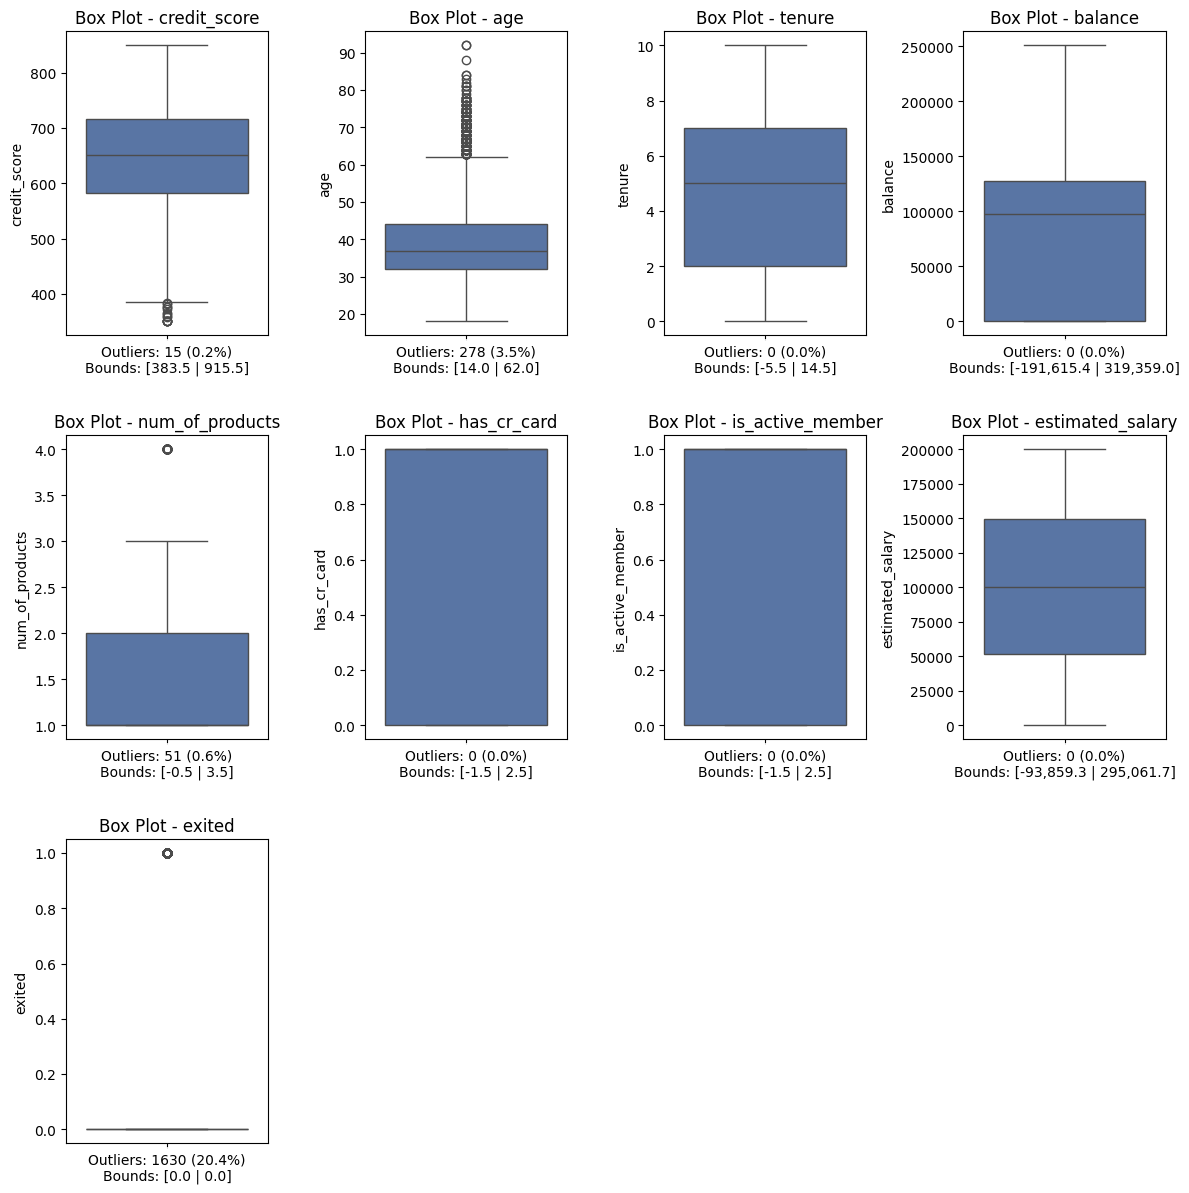

In [18]:
# Visualize and analyze outliers in numeric features using box plots and IQR method
inspect_outliers(train, numeric_cols)

Considerations:
- Outliers were identified on features: credit score, age, mum_of_products and exited.
- Examining the values considered outliers, it is visible that they are actually acceptable values for each features, like and age > 62.
- Therefore, they won't be considered outliers, and won't be removed from the dataset.

# EDA

## Univariate Analysis

### Descriptive Analysis

Composed of:
- Location Metrics (central tendency), that show where the data is centered, such as mean and median.
- Variability Metrics (cispersion), that reveal how the values are spread around that center, such as standard deviation, quantiles, skewness and kurtosis.

Below, all the numerical variables in the dataset will be analyzed.

In [19]:
statistics(train)

,non-null,range,min,quant25,median,quant75,max,mean,std,skew,kurtosis
credit_score,8000,500.0,350.0,583.0,652.0,716.0,850.0,649.9,96.7,-0.1,-0.4
age,8000,74.0,18.0,32.0,37.0,44.0,92.0,38.9,10.4,1.0,1.4
tenure,8000,10.0,0.0,2.0,5.0,7.0,10.0,5.0,2.9,0.0,-1.2
balance,8000,250898.1,0.0,0.0,97276.1,127743.6,250898.1,76673.7,62487.0,-0.1,-1.5
num_of_products,8000,3.0,1.0,1.0,1.0,2.0,4.0,1.5,0.6,0.8,0.6
has_cr_card,8000,1.0,0.0,0.0,1.0,1.0,1.0,0.7,0.5,-0.9,-1.2
is_active_member,8000,1.0,0.0,0.0,1.0,1.0,1.0,0.5,0.5,-0.1,-2.0
estimated_salary,8000,199902.4,90.1,51986.1,100487.7,149216.3,199992.5,100467.8,57274.2,-0.0,-1.2
exited,8000,1.0,0.0,0.0,0.0,0.0,1.0,0.2,0.4,1.5,0.2


Analysis:
- age: has positive kurtosis, so there is a spike arround the median.
- balance: quant25 shows 0.00, meaning at least 25% of data equals to zero. No negative values were found.
- num_of_products: max is 4, but median is 1, so at least 50% of customers have only 1 product.
- has_cr_card: negative skew shows that the concentration of values is high, so most customers have a credit card.
- estimated_salary: skew 0.00 shows that estimated salaries are not concentrated in low or high values, having an uniform distribuition.
- exited: positive skew shows that the concentration of values is low, with most values being zero, as expected for a churn problem.

### Target Analysis

Inspect the distribution of target variable with percentage labels.

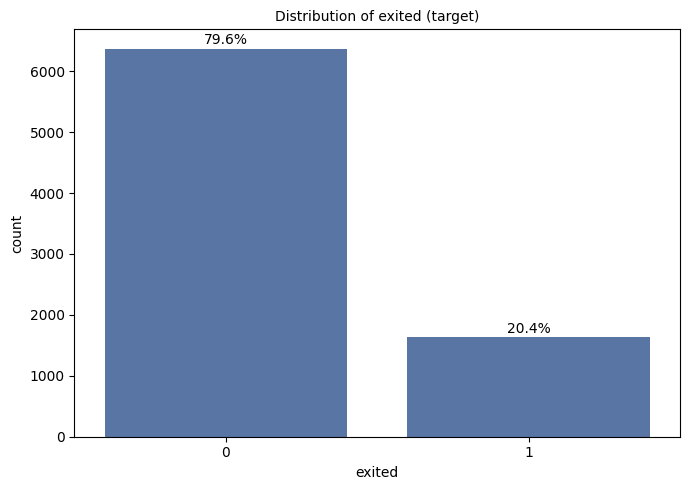

In [20]:
plot_target_distribution(train, 'exited', figsize=(7, 5))

As seen in descriptive analysis, this is an imbalanced dataset, with 20.4% of customers having churned.

### Numerical Analysis

 Inspect distributions of numerical features with histograms and KDE.

In [21]:
# Select numerical features 
train_num = train.select_dtypes(include=['int64', 'float64'])

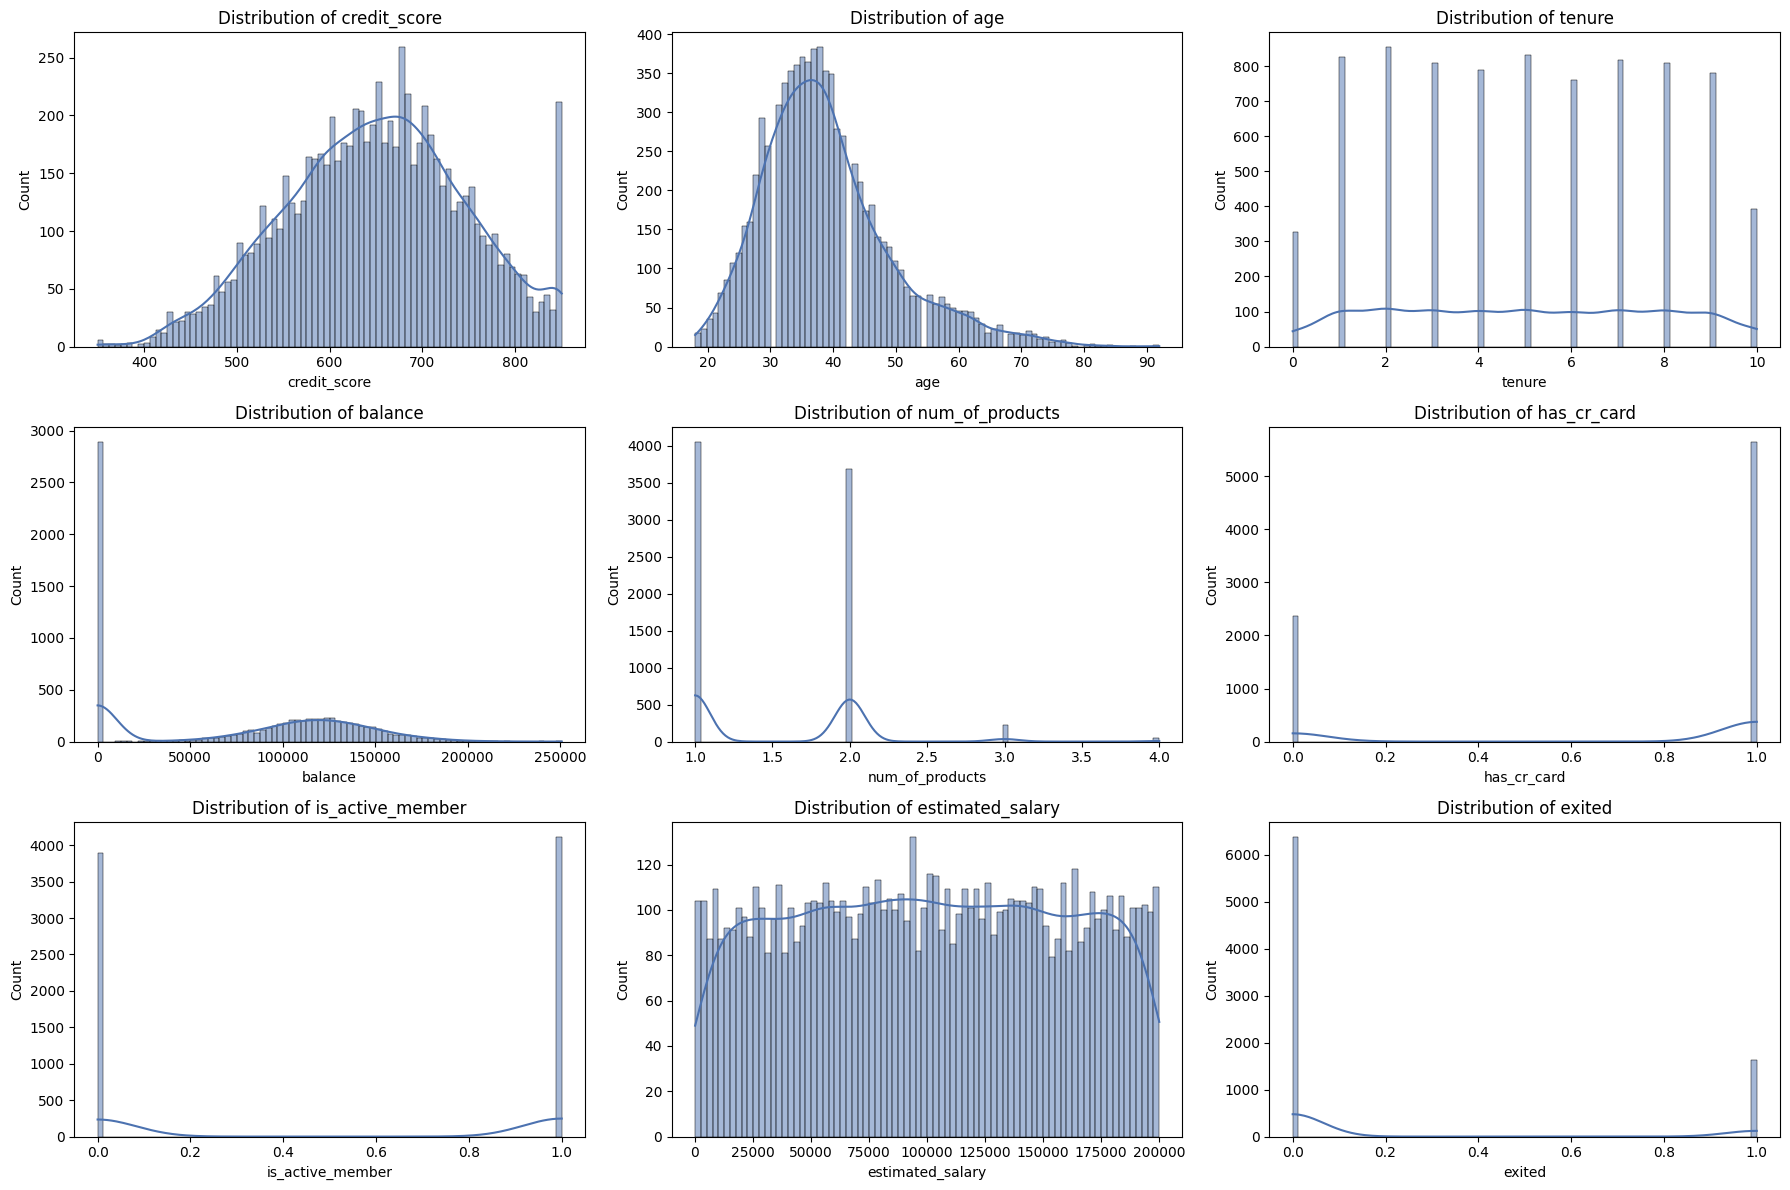

In [22]:
plot_numerical_distributions(train_num, figsize=(18, 4))

Considerations:

- Credit score: median is 652, so half of customers have score between 650 and 850. 
  - There is a spike on the right of the graph. I will inspect it:

In [23]:
# Inspect credit_score = 850
train_num.loc[train_num.credit_score == 850].credit_score.count()

184

- There are 184 customers with credit_score = 850:
  - There is really a spike on 850. Maybe it is the greatest value a customer can achieve. This may be validated with business team.
- Age: mean age is 39, and most frequent ages are betweem 30 and 40 years.
- Tenure: distribution is very homoegeneous, except for customers with 0 or 10 years.
- Balance: also has a spike on zero, but seems natural.
- Num of products: customers with more 3 or 4 products are really exceptions.
- Salary: distribuition is very uniform, except at the extremes.


### Categorical Analysis

Inspect distributions of categorical features using count plots.

In [24]:
# Select categorical features 
train_cat = train.select_dtypes(exclude=['int64', 'float64'])

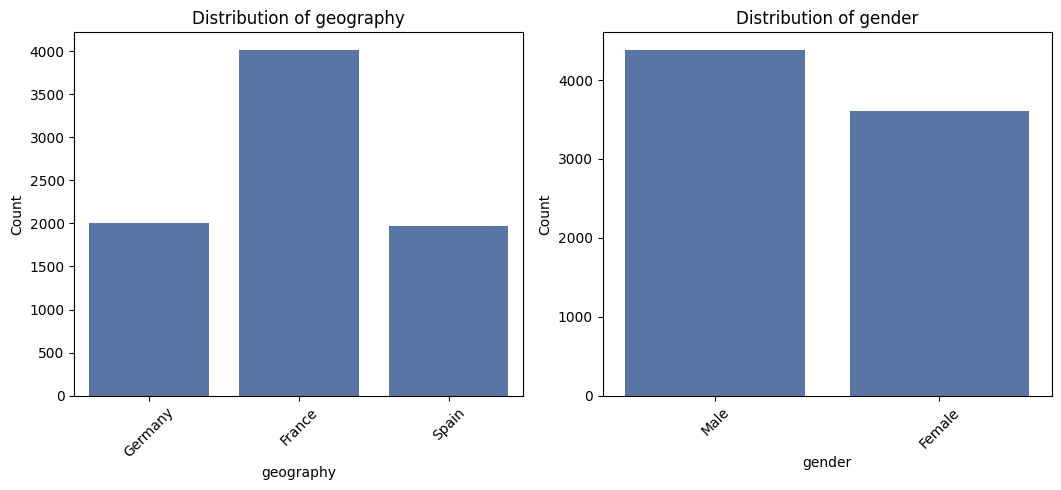

In [25]:
plot_categorical_distributions(train_cat, figsize=(16, 5))

Considerations:
- Geography: Half of customers of train dataset are from france.
- Gender: Male gender has a bit more customers than Female.

## Bivariate Analysis

Bivariate analyses will be performed using Sweetviz plots. 

Full report is available on reports/sv_report.html.

In [19]:
#Generate report
sv_report_df = sv.analyze(train, target_feat="exited") #
sv_report_df.show_html(filepath='../reports/sv_report.html',open_browser=False)

Done! Use 'show' commands to display/save.   |█████████████████████████████████████████| [100%]   00:00 -> (00:00 left)

Report ../reports/sv_report.html was generated.


The SweetViz report shows that:

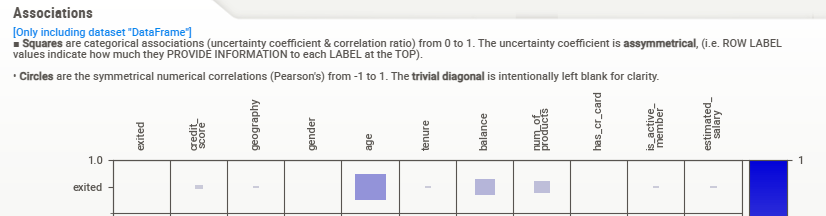
- churn (exited) -> is mostly associated categorically with: age, balance and num_of_products.

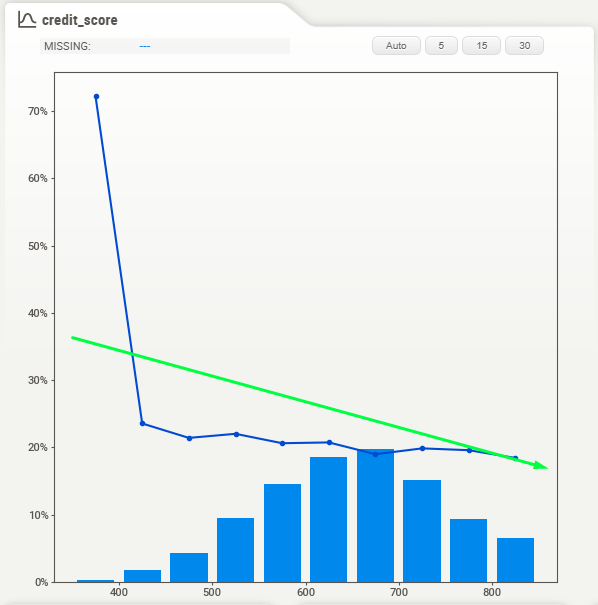
- Credit score -> as the customer's credit score increases, churn drops.

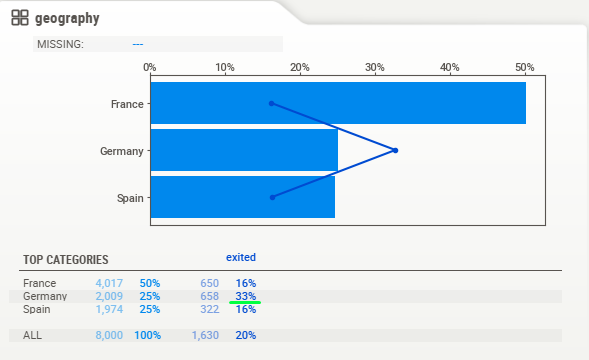
- geography -> Germany customers churn more: 33% of customers in Germany churned, vs 16% in France and Spain (less than half).

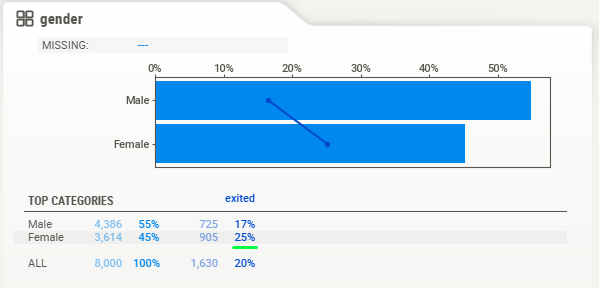
- gender -> female customers churn more: 25% of them churned, vs 17% of male.

Possible feature engineering: 
- Creates gender vs geography groups, resulting in a new feature that summarizes the information content of both.

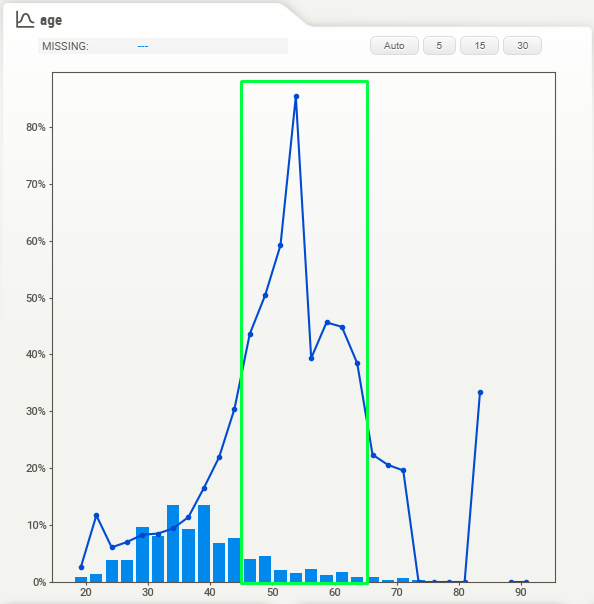
- age -> churn seems to be more concentrated on customers with age between 45 and 65 years, but there are few customers with more than 50 years. I will inspect this below:

#### H1) Customers with age between 45 and 65 years churn more than other ages.

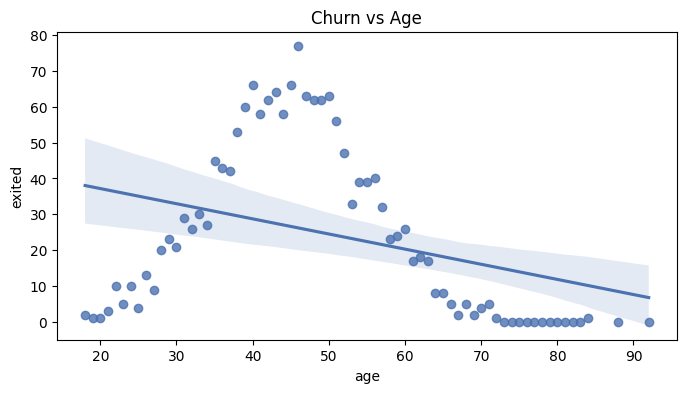

In [26]:
# Churn vs age:
plt.figure(figsize=(8, 4))
aux_h1 = train[['age', 'exited']].groupby('age').sum().reset_index();
plt_h1 = sns.regplot (x= 'age', y='exited', data=aux_h1).set_title('Churn vs Age');

H1) Customers with age between 45 and 65 years churn more than other ages.
- FALSE: customers with most churns were those from 35 to 55 years.

Possible feature engineering: 
- Create age groups from age, calibrating to make them balanced.
  - In this way, in the case of ages that are underrepresented, the bin may make it easier for the model to recognize them.

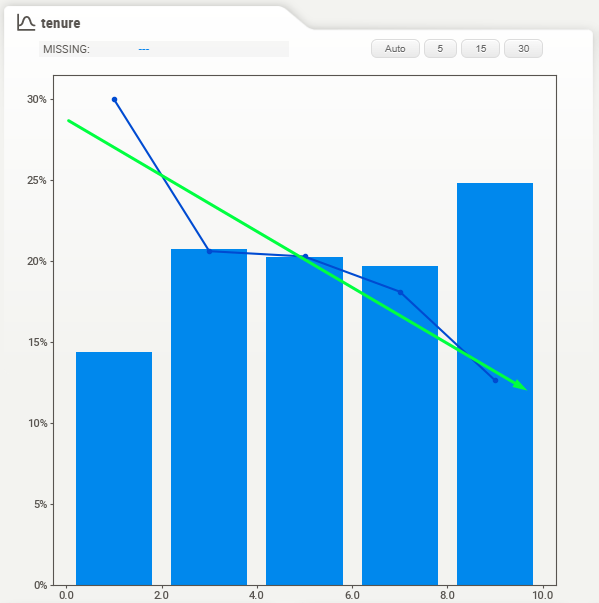
- Tenure -> order customers churn less: the older the customer, the less he churned.

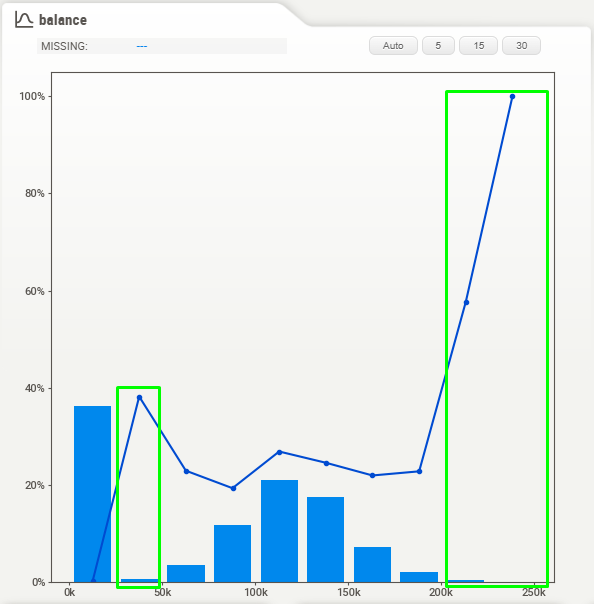

balance -> customer on the tail of the distribution seem to have churned more: except customers with a balance = 0, those with less than 50k and with more than 200k churned more.

Since a minimum volumetry in the bins highlighted in green is necessary to consider this higher churn as statistically significant, I will inspect this below:

In [27]:
# Number of customers on green highlighted bins:
train.loc[(train.balance != 0) & (train.balance < 50000) | (train.balance > 200000)].shape[0]

90

In [28]:
# How much % they represent of total dataset?
train.loc[(train.balance != 0) & (train.balance < 50000) | (train.balance > 200000)].shape[0] / train.shape[0] *100

1.125

When studying correlational relationships, recommended sample sizes are between 500-1000.

So, the proportion (1.1%) is too small to make reliable inferences about behavior patterns. The findings might be due to random chance rather than a true pattern.

In this scenario, looks like customers in the middle of distribution churn mode. I will inspect this below:

#### H2) Customers with balances in the range of 100 and 150k churn more than customers with other balance ranges

Create balance bands:

In [29]:
#zero will be a specific one, since there are many customers with this balance:
train['balance_group'] = pd.cut(
    train['balance'],
    bins = [-1, 0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, float('inf')],
    labels = ['0', '1-25k', '25k-50k', '50k-75k', '75k-100k', '100k-125k', '125k-150k', '150k-175k', '175k-200k', '200k-225k', '225k-250k'],
    right=True
)

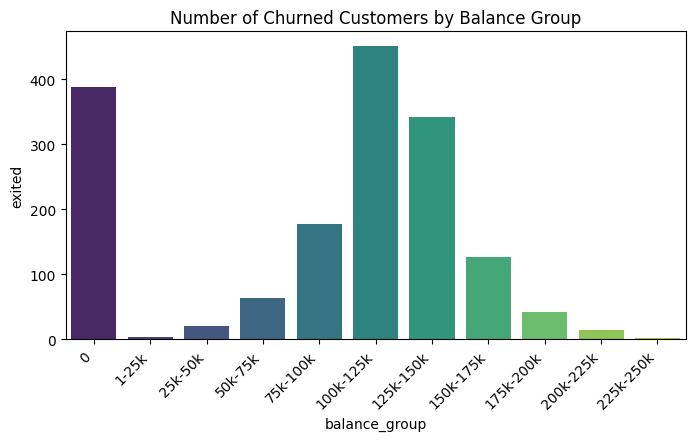

In [30]:
# Group data by balance_group and calculate sum of churned customers:
balance_churn = train[['balance_group', 'exited']].groupby('balance_group', observed=True).sum().reset_index()
plt.figure(figsize=(8, 4))
sns.barplot(x='balance_group', y='exited', data=balance_churn, hue='balance_group', palette='viridis', legend=False) 
plt.title('Number of Churned Customers by Balance Group');
plt.xticks(rotation=45, ha='right');

H2) Customers with balance between 100 and 150k churn more customers with other balances.
- FALSE: Customers with balance = 0 churn more than those on band 125-150k. Customers on band 100-125k are those with most churn cases.

Possible feature engineering: 
- Create balance_groups from balance, expliciting the behavior seen above.

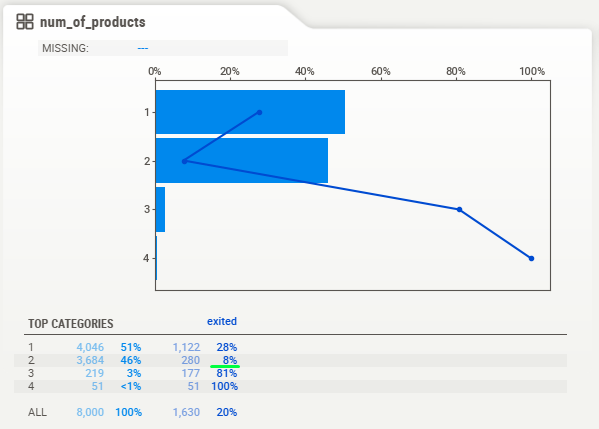
- num_of_products:
  - customers with 2 products churned less (8%).
  - customers with 1 product churned more (28%).
  - customers with 3 products churned even more (81%).
  - 100% of customers with 4 products churned.

Possible feature engineering: 
- Create a scale for num_of_product: "C" for 2 products, "B" for 1 product, "A" for 3 or 4 products (3 groups), in order to create a kind of scale by churn level, helping models to identify churn.

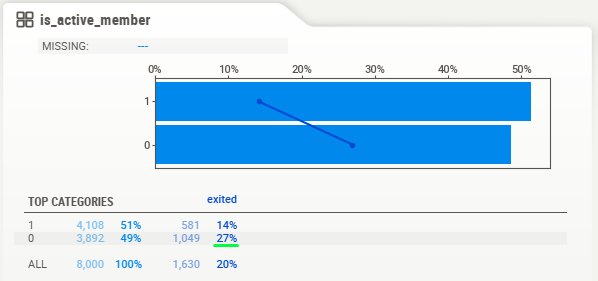
- is_active_member -> inactive members churn more: 27% of churn comes from inactive members, while 14% came from active members.

This insights may be shared with business team, as inputs for actions aimed at reducing churn.

## Multivariate Analysis

### Pearson's Correlation 


Pearson's correlation coefficient will be used to measure the strength and direction of the linear relationship between numeric variables.
- Interpretation: Ranges from -1 to +1:
  - -1 = perfect negative correlation.
  - 0 = no correlation.
  - 1 = perfect correlation.  

- Assumptions:
    - Continuous variables, even on different scales.
    - Linearity: features must have a linear relationship.
    - Outliers: Sensitive to outliers.
    - Normality: more important for statistical significance, and less for the interpretation of the coefficient value.
    - Homoscedasticity: Variance of residuals should be constant.
    - Data independence: Observations must be independent.


Plot Pearson correlation matrix for numerical variables.

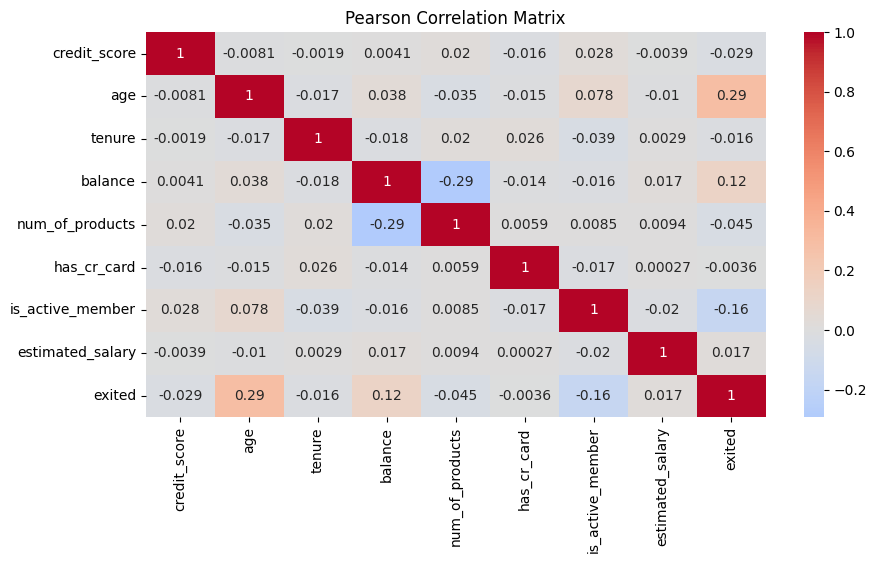

In [31]:
plot_pearson_correlation(train_num)

Correlation Considerations:
- age and exited: shows the strongest positive correlation (0.29). This suggests older customers are more likely to churn.
- is_active_member and exited: shows some negative correlation (-0.16). This suggests active members are less likely to churn.
- balance and exited: shows a weak positive correlation (0.12). This suggests customers with higher balances have a slightly higher tendency to churn.

Feature Interactions:
- balance and num_of_products: shows the strongest negative correlation (-0.29) among features. This suggests customers with higher balances tend to have fewer products.

### Cramér's V

Cramér's V statistical measure, based on chi-square statistic, will be used to evaluate the strength of association between categorical variables.

- Interpretation: ranges from 0 (no association) to 1 (perfect association):
    - 0.0 to 0.1: Negligible association
    - 0.1 to 0.3: Weak association
    - 0.3 to 0.5: Moderate association
    - 0.5 to 0.7: Strong association
    - 0.7 to 1.0: Very strong association

Assumptions:
- Categorical variables.
- Independence between the vars.
- Sample size: more reliable results are obtained with larger sample sizes.
- Frequency distribution: Each cell in contingency table should have expected frequency ≥ 5. This ensures chi-square test validity.

In [32]:
# Combine categorical features with target
train_cat_with_tgt = pd.concat([train_cat, train_num['exited']], axis=1)

Plot Cramér's V correlations between categorical variables as a heatmap.

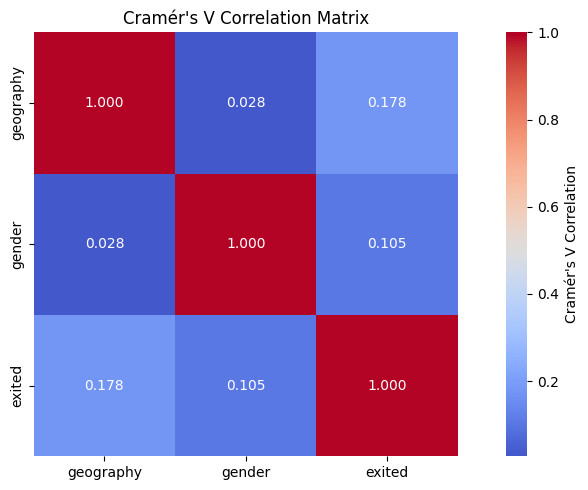

In [33]:
plot_categorical_correlations(train_cat_with_tgt)

Correlation Considerations:
- geography and exiter: shows some positive correlation (0.18). This suggests customer location has some influence on churn behavior.
- gender and exited: shows a weak positive correlation (0.10). This suggests gender has a minor but noticeable influence on churn.